In [338]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms

from time import time
from xgboost import XGBClassifier
from itertools import chain
from sktime.datasets import load_from_tsfile_to_dataframe

from scipy.signal import find_peaks
from scipy.stats import iqr, skew, kurtosis

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.ensemble import RandomForestClassifier


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [428]:
def timer(func):
    def inner(*args, **kwargs):
        start = time()
        res = func(*args, **kwargs)
        print(f'Finished in {time() - start}s')
        return res
    return inner

In [3]:
class PEMS:
    @timer
    def __init__(self):
        self.train_x_df, self.train_y = load_from_tsfile_to_dataframe('PEMS-SF/PEMS-SF_TRAIN.ts')
        self.test_x_df, self.test_y = load_from_tsfile_to_dataframe('PEMS-SF/PEMS-SF_TEST.ts')
        self.train_x = np.array([[x.to_numpy() for x in dim] for dim in self.train_x_df.to_numpy()])
        self.train_x.resize((self.train_x.shape[0], self.train_x.shape[1] * self.train_x.shape[2]))
        self.test_x = np.array([[x.to_numpy() for x in dim] for dim in self.test_x_df.to_numpy()])
        self.test_x.resize((self.test_x.shape[0], self.test_x.shape[1] * self.test_x.shape[2]))
        self.train_y = np.array([round(float(cls)) - 1 for cls in self.train_y])
        self.test_y = np.array([round(float(cls)) - 1 for cls in self.test_y])

        selector1, selector2 = VarianceThreshold(0.005), SelectPercentile(percentile=50)
        self.train_selected = selector2.fit_transform(selector1.fit_transform(self.train_x, self.train_y), self.train_y)
        self.test_selected = selector2.transform(selector1.transform(self.test_x))

        self.train_extracted = None
        self.test_extracted = None

    @timer
    def feature_extraction(self):
        data = []
        for sample in chain(self.train_x_df.to_numpy(), self.test_x_df.to_numpy()):
            features = []
            for window in np.array([x.to_numpy() for x in sample]):
                    features.extend([
                        np.mean(window),
                        np.std(window),
                        np.mean(np.absolute(window - np.mean(window))),
                        np.min(window),
                        np.max(window),
                        np.max(window[36: 72]),
                        np.max(window[96:112]),
                        np.max(window) - np.min(window),
                        np.median(window),
                        np.median(np.absolute(window - np.median(window))),
                        iqr(window),
                        np.percentile(window, 25),
                        np.percentile(window, 75),
                        np.sum(window > window.mean()),
                        len(find_peaks(window)),
                        skew(window),
                        kurtosis(window),
                        np.argmax(window),
                        np.argmax(window[36: 72]),
                        np.argmax(window[96:112]),
                        np.argmin(window),
                    ])
            data.append(features)
        self.train_extracted = np.array(data[:self.train_y.shape[0]])
        self.test_extracted = np.array(data[self.train_y.shape[0]:])

In [4]:
class UWave:
    @timer
    def __init__(self):
        self.train_x_df, self.train_y = load_from_tsfile_to_dataframe('UWaveGestureLibraryAll/UWaveGestureLibraryAll_TEST.ts')
        self.test_x_df, self.test_y = load_from_tsfile_to_dataframe('UWaveGestureLibraryAll/UWaveGestureLibraryAll_TRAIN.ts')
        self.train_x = np.array([x[0].to_numpy() for x in self.train_x_df.to_numpy()])
        self.test_x = np.array([x[0].to_numpy() for x in self.test_x_df.to_numpy()])
        self.train_y = np.array([round(float(cls)) - 1 for cls in self.train_y])
        self.test_y = np.array([round(float(cls)) - 1 for cls in self.test_y])

        selector1, selector2 = VarianceThreshold(0.995), SelectPercentile(percentile=20)
        self.train_selected = selector2.fit_transform(selector1.fit_transform(self.train_x, self.train_y), self.train_y)
        self.test_selected = selector2.transform(selector1.transform(self.test_x))

        self.train_extracted = None
        self.test_extracted = None

    @timer
    def feature_extraction(self):
        data = []
        for sample in chain(self.train_x_df.to_numpy(), self.test_x_df.to_numpy()):
            sample = sample[0]
            features = [np.sum(sample) / 100]
            for i in range(0, 945, 315):
                for j in range(i, i + 315, 105):
                    window = sample[j : j + 105]
                    fft = np.abs(np.fft.fft(window))[1:51]
                    features.extend([
                        np.mean(window),
                        np.std(window),
                        np.mean(np.absolute(window - np.mean(window))),
                        np.min(window),
                        np.max(window),
                        np.max(window) - np.min(window),
                        np.median(window),
                        np.median(np.absolute(window - np.median(window))),
                        iqr(window),
                        np.sum(window < 0),
                        np.sum(window > 0),
                        np.sum(window > window.mean()),
                        len(find_peaks(window)),
                        skew(window),
                        kurtosis(window),
                        np.sum(window**2) / 100,
                        np.mean(fft),
                        np.std(fft),
                        np.mean(np.absolute(fft - np.mean(fft))),
                        np.min(fft),
                        np.max(fft),
                        np.max(fft) - np.min(fft),
                        np.median(fft),
                        np.median(np.absolute(fft - np.median(fft))),
                        iqr(fft),
                        np.sum(fft < 0),
                        np.sum(fft > 0),
                        np.sum(fft > fft.mean()),
                        len(find_peaks(fft)),
                        skew(fft),
                        kurtosis(fft),
                        np.sum(fft**2) / 100,
                        np.argmax(window),
                        np.argmin(window),
                        np.argmax(fft),
                        np.argmin(fft),
                    ])
            data.append(features)
        self.train_extracted = np.array(data[:self.train_y.shape[0]])
        self.test_extracted = np.array(data[self.train_y.shape[0]:])

        selector1, selector2 = VarianceThreshold(0.5), SelectPercentile(percentile=50)
        self.train_extracted = selector2.fit_transform(selector1.fit_transform(self.train_extracted, uwave.train_y), self.train_y)
        self.test_extracted = selector2.transform(selector1.transform(self.test_extracted))

In [5]:
pems = PEMS()
pems.feature_extraction()

C:\Users\Adrian\.conda\envs\cuda\lib\site-packages\sktime\datasets\_data_io.py:928: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["dim_" + str(dim)] = instance_list[dim]
C:\Users\Adrian\.conda\envs\cuda\lib\site-packages\sktime\datasets\_data_io.py:928: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["dim_" + str(dim)] = instance_list[dim]
C:\Users\Adrian\.conda\envs\cuda\lib\site-packages\sktime\datasets\_data_io.py:928: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.in

Finished in 136.1974151134491s
Finished in 365.86132860183716s


In [6]:
uwave = UWave()
uwave.feature_extraction()

Finished in 2.717033624649048s
Finished in 126.48673748970032s


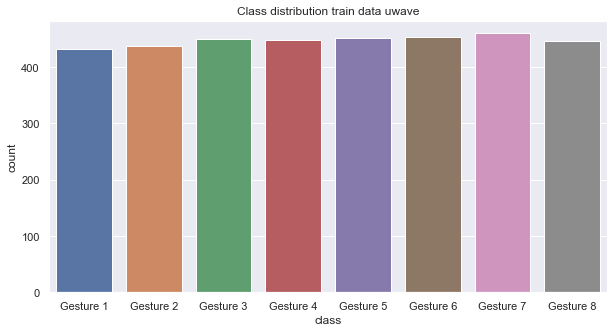

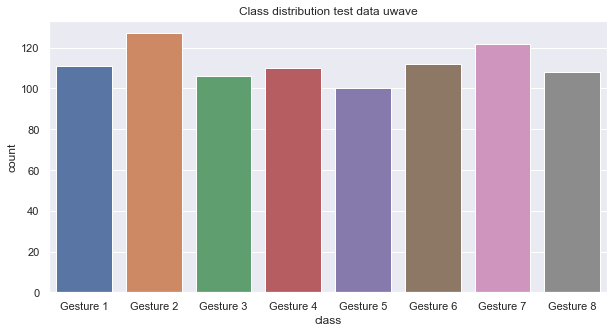

In [134]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 5))
data = pd.DataFrame()
data['count'] = pd.Series(uwave.train_y)
data['labels'] = pd.Series( [f'Gesture {i + 1}' for i in uwave.train_y])
sns.countplot(x='labels', data=data)
plt.title('Class distribution train data uwave')
plt.xticks(range(8), [f'Gesture {i + 1}' for i in range(8)])
plt.xlabel('class')
plt.ylabel('count')
plt.show()
plt.figure(figsize=(10, 5))
data['count'] = pd.Series(uwave.test_y)
data['labels'] = pd.Series( [f'Gesture {i + 1}' for i in uwave.test_y])
sns.countplot(x='labels', data=data)
plt.title('Class distribution test data uwave')
plt.xticks(range(8), [f'Gesture {i + 1}' for i in range(8)])
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [ ]:
gestures = [{'x': [], 'y': [], 'z': []} for _ in range(8)]
for (x, y) in zip(uwave.train_x, uwave.train_y):
    gestures[y]['x'].extend([round(i, 2) for i in x[:315]])
    gestures[y]['y'].extend([round(i, 2) for i in x[315:630]])
    gestures[y]['z'].extend([round(i, 2) for i in x[630:]])

<Figure size 864x288 with 0 Axes>

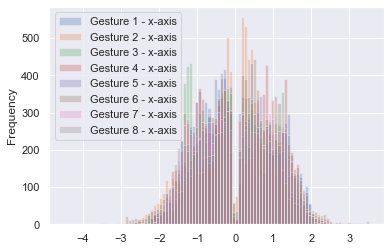

<Figure size 864x288 with 0 Axes>

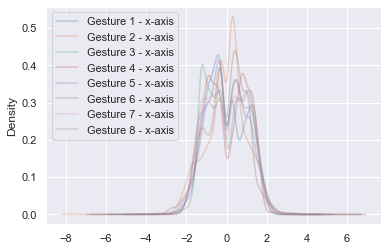

<Figure size 864x288 with 0 Axes>

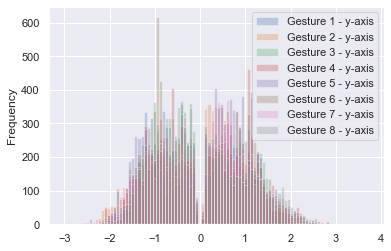

<Figure size 864x288 with 0 Axes>

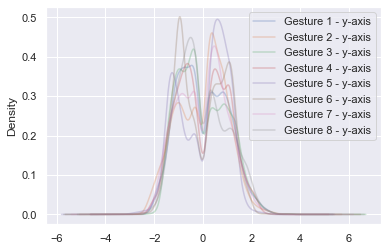

<Figure size 864x288 with 0 Axes>

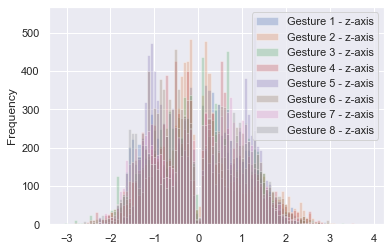

<Figure size 864x288 with 0 Axes>

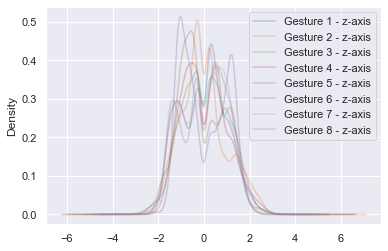

In [150]:
# gestures = np.array(gestures)
# print(gestures.shape)
# gestures_df = pd.DataFrame(data={f'Gesture {i + 1}': [pd.Series(g) for g in gestures] for i in range(8)})
# print(gestures_df)
# ax = sns.FacetGrid(gestures_df)
# ax.map(sns.histplot).add_legend()
for axis in ['x', 'y', 'z']:
    data = pd.DataFrame()
    for i in range(8):
        data[f'Gesture {i + 1} - {axis}-axis'] = gestures[i][axis][:10000]
    data.plot.hist(bins=100, alpha=0.3)
    plt.show()
    data.plot(kind='density', alpha=0.3)
    plt.show()

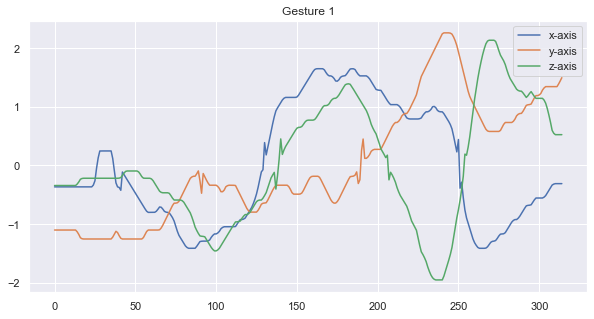

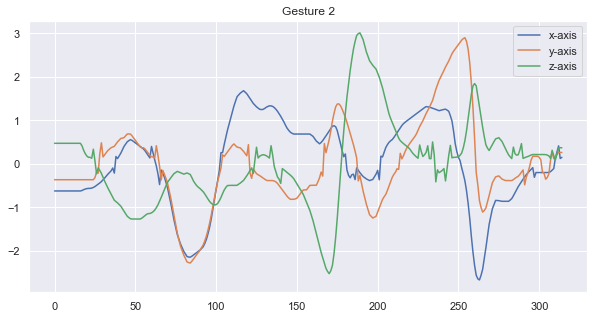

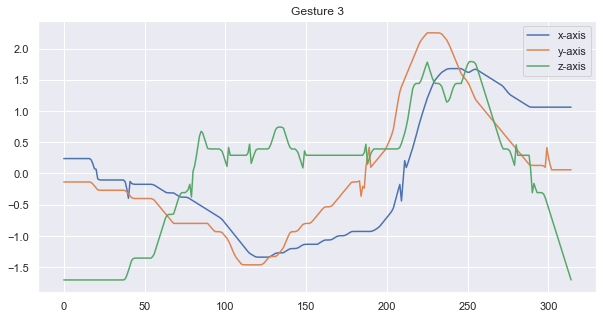

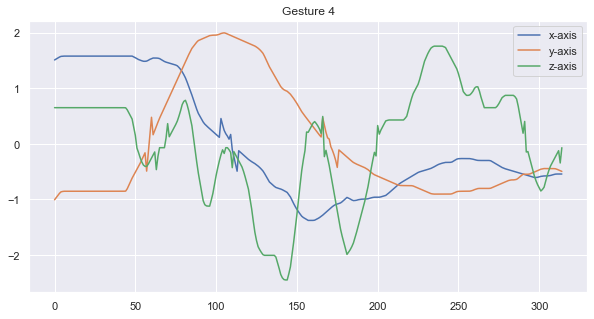

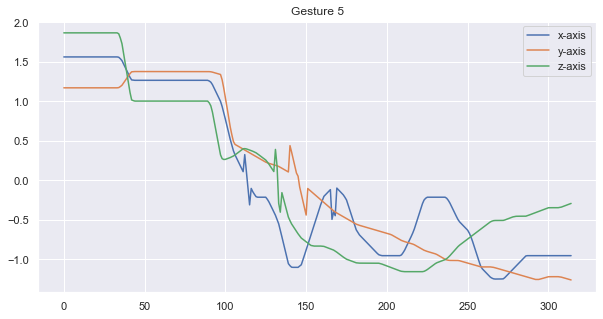

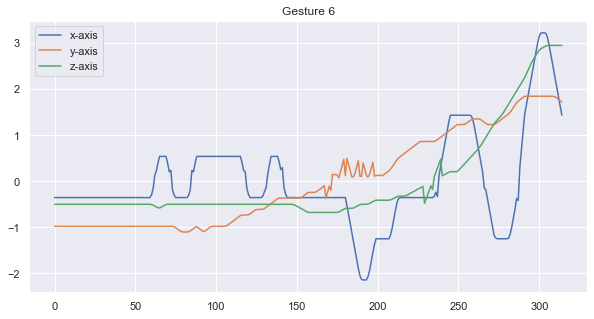

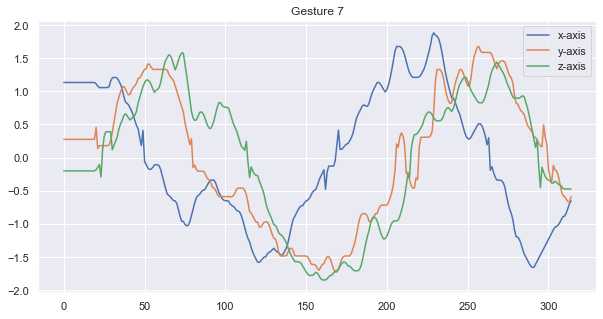

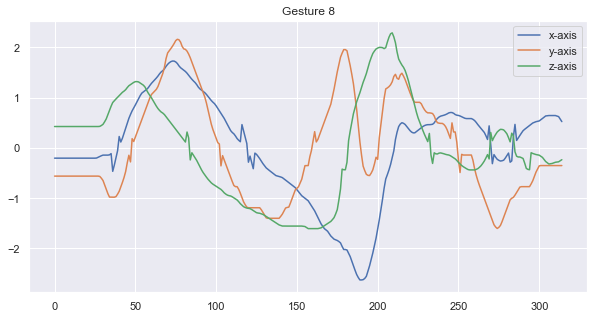

In [129]:
def plot_ex(sample, i):
    ex = [sample[:315], sample[315:630], sample[630:]]
    plt.figure(figsize=(10, 5))
    plt.title(f'Gesture {i + 1}')
    plt.plot(range(315), ex[0], label='x-axis')
    plt.plot(range(315), ex[1], label='y-axis')
    plt.plot(range(315), ex[2], label='z-axis')
    plt.legend()
    plt.show()

for i in range(8):
    for (x, y) in zip(uwave.train_x, uwave.train_y):
        if y == i:
            plot_ex(x, i)
            break

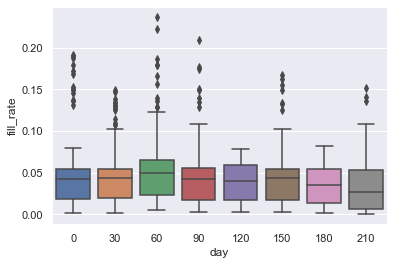

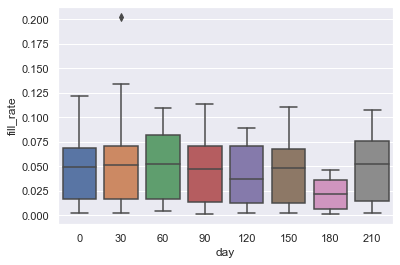

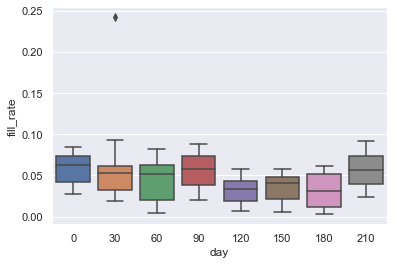

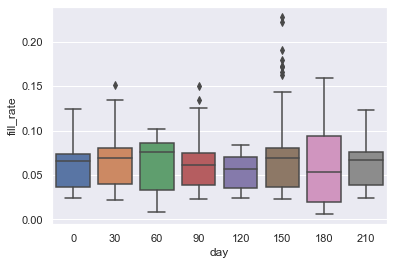

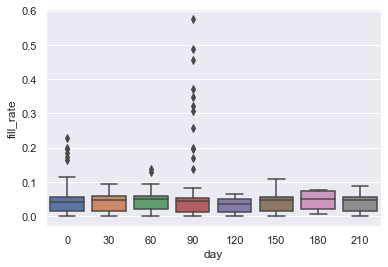

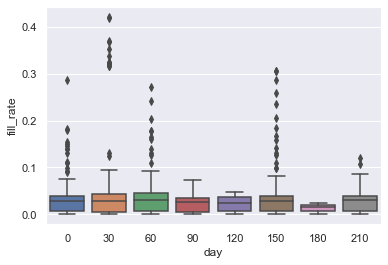

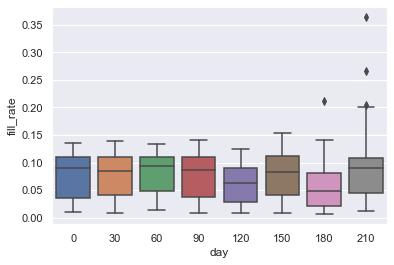

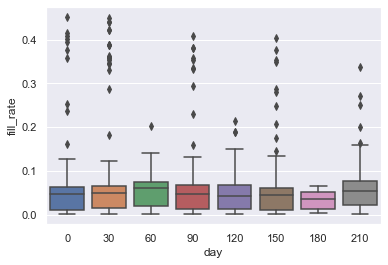

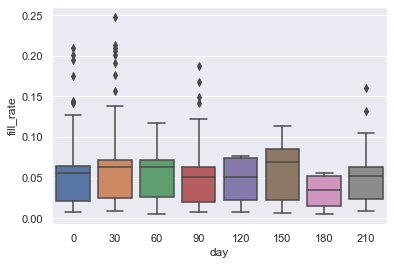

In [117]:
stds = list([(np.std(x), i) for i, x in enumerate([dim[0] for dim in pems.train_x_df.to_numpy()])])
stds.sort()
for _, std in stds[-1:-10:-1]:
    data = pd.DataFrame()
    lst, column = [], []
    for day in range(0, 240, 30):
        l = (pems.train_x_df[f'dim_{std}'][day])
        column.extend([day for _ in l])
        lst.extend(l)

    data['fill_rate'] = pd.Series(lst)
    data['day'] = pd.Series(column)
    ax = sns.boxplot(x='day', y='fill_rate', data=data)
    plt.show()

<Figure size 720x360 with 0 Axes>

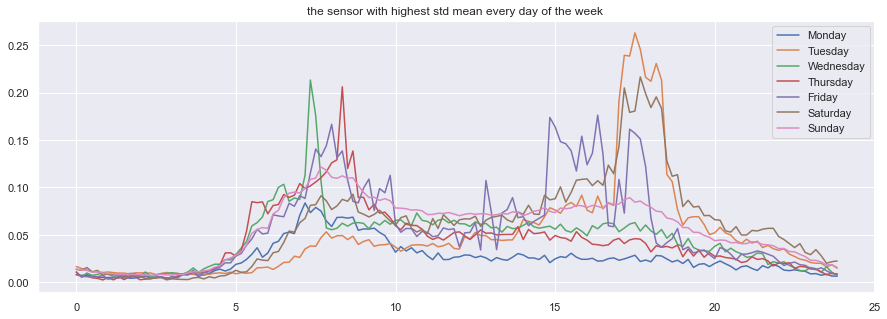

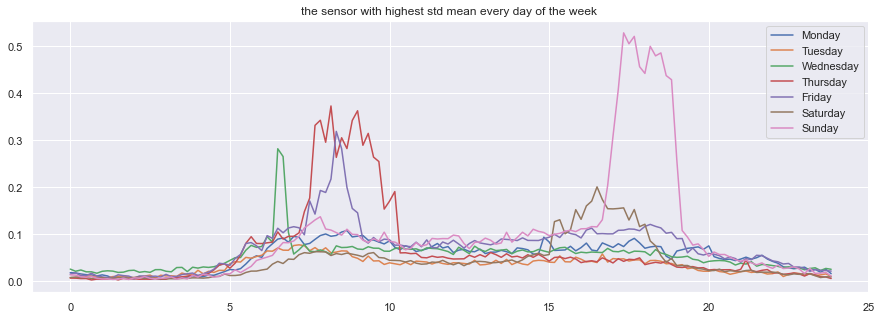

In [137]:
plt.figure(figsize=(10, 5))
days_index = [list(pems.train_y).index(i) for i in range(7)]
for i in [1, 111]:
    plt.figure(figsize=(15, 5))
    for day, day_index in enumerate(days_index):
        plt.title(f'the sensor with highest std mean every day of the week ')
        plt.plot([(i / 6) for i in range(144)], pems.train_x_df[f'dim_{day_index}'][i], label=days[day])
    plt.legend()
    plt.show()

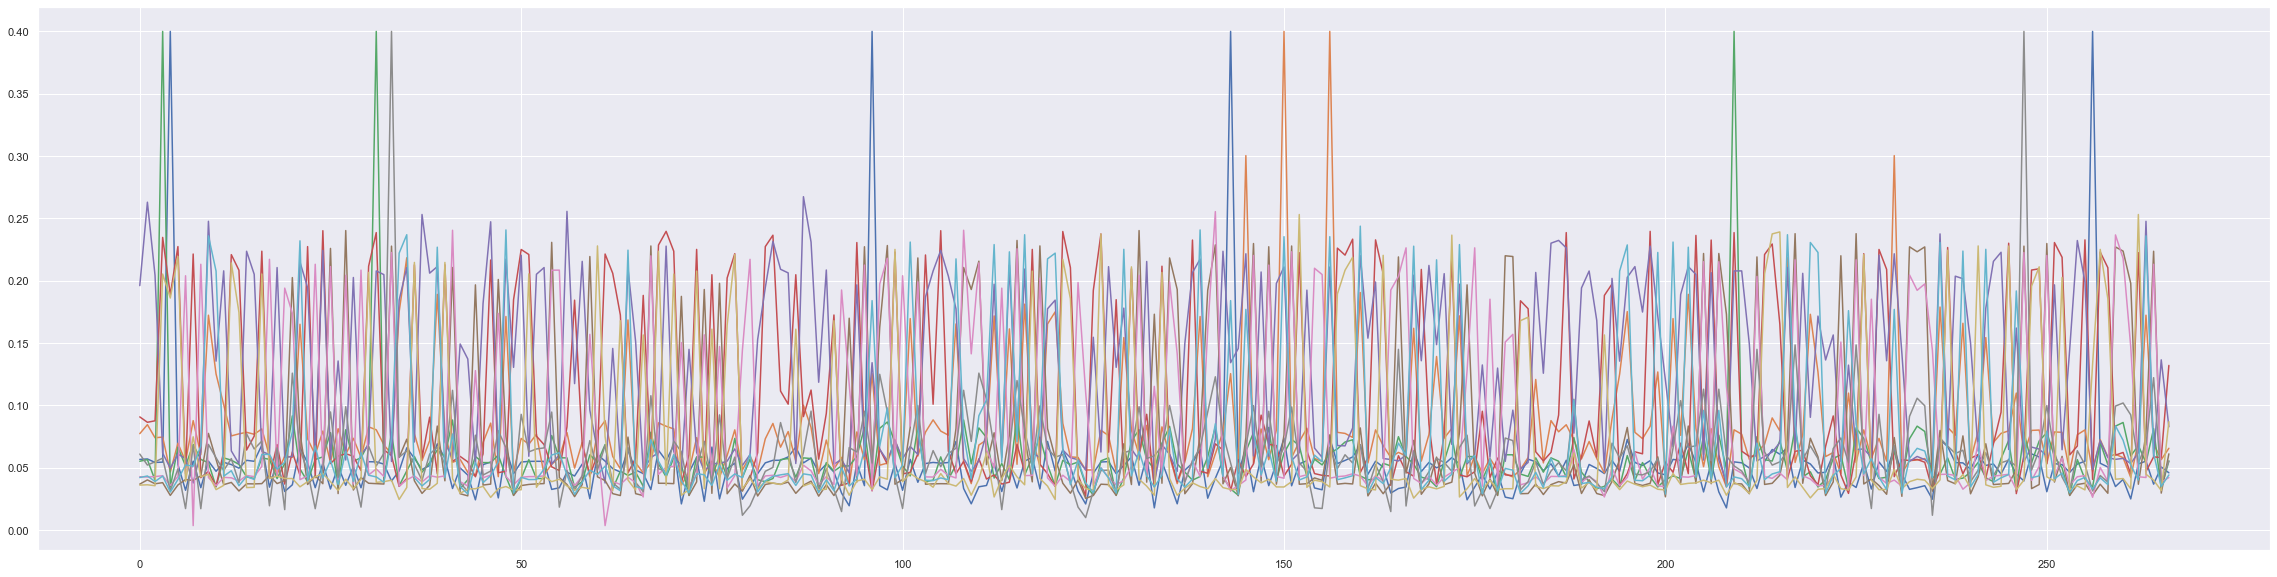

In [114]:
data = pd.DataFrame()
for dim in [f'dim_{i}' for i in range(963)]:
    data[dim] = pems.train_x_df[dim].apply(lambda x: np.mean(x))
std_mean = list([(np.std(x), i) for i, x in enumerate(data.to_numpy().transpose())])
std_mean.sort()
plt.figure(figsize=(40, 10))
for val, i in std_mean[-1:-11:-1]:
    plt.plot(range(267), [min(x, 0.4) for x in data.to_numpy().transpose()[i]])
plt.show()

In [245]:
@timer
def m():
    model = RandomForestClassifier(max_depth=100, n_estimators=100, n_jobs=12)
    # model = xgb.XGBClassifier(tree_method='gpu_hist')
    model.fit(pems.train_x, np.array([round(float(cls)) - 1 for cls in pems.train_y]))
    pred = model.predict(pems.test_x)
    print(accuracy_score(np.array([round(float(cls)) - 1 for cls in pems.test_y]), pred))
    print(classification_report(np.array([round(float(cls)) - 1 for cls in pems.test_y]), pred))

m()

0.9075144508670521
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.89      1.00      0.94        25
           2       1.00      0.85      0.92        26
           3       0.85      0.74      0.79        23
           4       0.95      0.82      0.88        22
           5       0.74      0.93      0.82        27
           6       1.00      1.00      1.00        20

    accuracy                           0.91       173
   macro avg       0.92      0.90      0.91       173
weighted avg       0.92      0.91      0.91       173

Finished in 0.22818803787231445s


In [9]:
gradientBoosted_tuned_parameters = [{'n_estimators': [10, 100, 1000], 'max_depth': [5, 15], 'learning_rate': [0.2, 0.3, 0.5],
                                     'tree_method': ['gpu_hist']}]
randomForest_tuned_parameters = [
            {"n_estimators": [100, 1000], "max_depth": [10, 100, 500], 'max_samples': [0.1, 0.2, 0.5]},
            {"n_estimators": [100, 1000], "max_depth": [10, 100, 500]}]
svc_tuned_parameters = [{"kernel": ["rbf", "linear", "poly"], "gamma": [1e-3, 1e-4], "C": [0.1, 1, 10]}]

In [41]:
@timer
def myGridSearch(estimator, data, typ, tuned_parameters):
    train, test = None, None
    if typ == 'selected':
        train, test = data.train_selected, data.test_selected
    elif typ == 'extracted':
        train, test = data.train_extracted, data.test_extracted
    elif typ == 'x':
        train, test = data.train_x, data.test_x

    model = GridSearchCV(estimator(), tuned_parameters, scoring="accuracy", n_jobs=12, pre_dispatch=3, cv=4, verbose=1)
    model.fit(train, data.train_y)
    
    print(f"Best parameters set found on development set:\n{model.best_params_}\n")
    
    means = model.cv_results_["mean_test_score"]
    stds = model.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, model.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    pred = model.predict(test)
    print(accuracy_score(data.test_y, pred))
    print(confusion_matrix(data.test_y, pred))

    return model

In [17]:
random_forest_model = myGridSearch(RandomForestClassifier, uwave, 'extracted', [{'n_estimators': [100]}])
svc_model = myGridSearch(SVC, uwave, 'extracted', [{"kernel": ["linear"], "C": [0.5, 1]}])
gbt_model = myGridSearch(XGBClassifier, uwave, 'extracted',
                         [{'n_estimators': [100], 'max_depth': [10], 'learning_rate': [0.2], 'tree_method': ['gpu_hist']}])

Best parameters set found on development set:
{'n_estimators': 100}

0.956 (+/-0.008) for {'n_estimators': 100}
0.9665178571428571
[[117   0   0   1   1   3   0   0]
 [  1 106   0   0   0   0   1   0]
 [  0   0 105   0   1   0   0   0]
 [  1   0   0 106   2   0   0   1]
 [  0   0   1   2 123   1   0   0]
 [  3   0   2   7   0  99   0   0]
 [  0   0   1   0   0   0 111   0]
 [  0   0   1   0   0   0   0  99]]
Finished in 3.6059980392456055s
Best parameters set found on development set:
{'C': 0.5, 'kernel': 'linear'}

0.931 (+/-0.005) for {'C': 0.5, 'kernel': 'linear'}
0.929 (+/-0.006) for {'C': 1, 'kernel': 'linear'}
0.9352678571428571
[[115   0   0   0   2   5   0   0]
 [  0 105   0   0   0   0   2   1]
 [  0   0 102   0   0   1   2   1]
 [  3   0   0 100   4   0   1   2]
 [  0   0   3   2 118   3   0   1]
 [  0   0   2   8   1  99   0   1]
 [  2   2   1   1   0   1 105   0]
 [  0   0   1   1   0   2   2  94]]
Finished in 18.65045690536499s
Best parameters set found on development set:

In [22]:
gc.collect()
random_forest_uwave_x = myGridSearch(RandomForestClassifier, uwave, 'x', [
                                        {"n_estimators": [100, 1000], "max_depth": [10, 100, 500], 'max_samples': [0.1, 0.2, 0.5]},
                                        {"n_estimators": [100, 1000], "max_depth": [10, 100, 500]}
                                     ])

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best parameters set found on development set:
{'max_depth': 100, 'n_estimators': 1000}

0.914 (+/-0.010) for {'max_depth': 10, 'max_samples': 0.1, 'n_estimators': 100}
0.926 (+/-0.006) for {'max_depth': 10, 'max_samples': 0.1, 'n_estimators': 1000}
0.933 (+/-0.012) for {'max_depth': 10, 'max_samples': 0.2, 'n_estimators': 100}
0.938 (+/-0.015) for {'max_depth': 10, 'max_samples': 0.2, 'n_estimators': 1000}
0.948 (+/-0.015) for {'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 100}
0.951 (+/-0.016) for {'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 1000}
0.920 (+/-0.008) for {'max_depth': 100, 'max_samples': 0.1, 'n_estimators': 100}
0.926 (+/-0.011) for {'max_depth': 100, 'max_samples': 0.1, 'n_estimators': 1000}
0.937 (+/-0.013) for {'max_depth': 100, 'max_samples': 0.2, 'n_estimators': 100}
0.940 (+/-0.014) for {'max_depth': 100, 'max_samples': 0.2, 'n_estimators': 1000}
0.949 (+/-0.012) for {'max_depth': 100, 'm

In [23]:
gc.collect()
random_forest_uwave_selected = myGridSearch(RandomForestClassifier, uwave, 'selected', [
                                        {"n_estimators": [100, 1000], "max_depth": [10, 100, 500], 'max_samples': [0.5]},
                                        {"n_estimators": [100, 1000], "max_depth": [10, 100, 500]}
                                     ])

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters set found on development set:
{'max_depth': 100, 'n_estimators': 1000}

0.813 (+/-0.015) for {'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 100}
0.813 (+/-0.021) for {'max_depth': 10, 'max_samples': 0.5, 'n_estimators': 1000}
0.815 (+/-0.012) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 100}
0.821 (+/-0.011) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 1000}
0.819 (+/-0.007) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 100}
0.817 (+/-0.012) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 1000}
0.814 (+/-0.020) for {'max_depth': 10, 'n_estimators': 100}
0.819 (+/-0.017) for {'max_depth': 10, 'n_estimators': 1000}
0.826 (+/-0.009) for {'max_depth': 100, 'n_estimators': 100}
0.831 (+/-0.006) for {'max_depth': 100, 'n_estimators': 1000}
0.826 (+/-0.017) for {'max_depth': 500, 'n_estimators': 100}
0.829 (+/-0.007) for {'max_depth': 500, 'n_estimators': 100

In [24]:
gc.collect()
random_forest_uwave_extracted = myGridSearch(RandomForestClassifier, uwave, 'extracted', [
                                        {"n_estimators": [100, 1000], "max_depth": [100, 500], 'max_samples': [0.5]},
                                        {"n_estimators": [100, 200, 1000], "max_depth": [100, 200, 500]}
                                     ])

Fitting 4 folds for each of 13 candidates, totalling 52 fits
Best parameters set found on development set:
{'max_depth': 500, 'n_estimators': 1000}

0.948 (+/-0.008) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 100}
0.952 (+/-0.006) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 1000}
0.950 (+/-0.005) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 100}
0.951 (+/-0.002) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 1000}
0.958 (+/-0.012) for {'max_depth': 100, 'n_estimators': 100}
0.956 (+/-0.007) for {'max_depth': 100, 'n_estimators': 200}
0.957 (+/-0.009) for {'max_depth': 100, 'n_estimators': 1000}
0.954 (+/-0.005) for {'max_depth': 200, 'n_estimators': 100}
0.958 (+/-0.007) for {'max_depth': 200, 'n_estimators': 200}
0.958 (+/-0.008) for {'max_depth': 200, 'n_estimators': 1000}
0.957 (+/-0.007) for {'max_depth': 500, 'n_estimators': 100}
0.957 (+/-0.008) for {'max_depth': 500, 'n_estimators': 200}
0.960 (+/-0.008) for {'max_depth': 

In [25]:
gc.collect()
svc_uwave_x = myGridSearch(SVC, uwave, 'x', [{"kernel": ["rbf", "linear", "poly"], "gamma": [1e-3, 1e-4], "C": [0.2, 0.5, 1, 5, 10]}])

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best parameters set found on development set:
{'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}

0.950 (+/-0.007) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
0.892 (+/-0.010) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'linear'}
0.945 (+/-0.008) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
0.891 (+/-0.009) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
0.892 (+/-0.010) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'linear'}
0.128 (+/-0.000) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'poly'}
0.964 (+/-0.003) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.881 (+/-0.010) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
0.958 (+/-0.008) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
0.910 (+/-0.006) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.881 (+/-0.010) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'linear'}
0.128 (+/-0.000) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
0.970 (+/-0.005) for {'C': 1, 'gamma': 0.001, '

In [27]:
gc.collect()
svc_uwave_selected = myGridSearch(SVC, uwave, 'selected',
                                  [{"kernel": ["rbf", "linear", "poly"], "gamma": [1e-3, 1e-4], "C": [0.2, 0.5, 1, 5, 10]}])

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

0.682 (+/-0.023) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
0.727 (+/-0.007) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'linear'}
0.128 (+/-0.000) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
0.569 (+/-0.028) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
0.727 (+/-0.007) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'linear'}
0.128 (+/-0.000) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'poly'}
0.696 (+/-0.015) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.730 (+/-0.013) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
0.133 (+/-0.003) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
0.643 (+/-0.024) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.730 (+/-0.013) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'linear'}
0.128 (+/-0.000) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
0.707 (+/-0.019) for {'C': 1, 'gamma': 0.001, 

In [28]:
gc.collect()
svc_uwave_extracted = myGridSearch(SVC, uwave, 'extracted',
                                  [{"kernel": ["rbf", "linear", "poly"], "gamma": [1e-3, 1e-4], "C": [0.2, 0.5, 1, 5, 10]}])

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best parameters set found on development set:
{'C': 0.2, 'gamma': 0.001, 'kernel': 'poly'}

0.128 (+/-0.000) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
0.935 (+/-0.009) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'linear'}
0.967 (+/-0.005) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
0.928 (+/-0.016) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
0.935 (+/-0.009) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'linear'}
0.967 (+/-0.005) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'poly'}
0.129 (+/-0.001) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.931 (+/-0.005) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'linear'}
0.967 (+/-0.005) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'poly'}
0.948 (+/-0.003) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.931 (+/-0.005) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'linear'}
0.967 (+/-0.005) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'poly'}
0.356 (+/-0.010) for {'C': 1, 'gamma': 0.001

GBT
-

In [33]:
gc.collect()
gbt_uwave_x = myGridSearch(XGBClassifier, uwave, 'x',
                                   [{'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.2, 0.3, 0.5], 'tree_method': ['gpu_hist']}])

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters set found on development set:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}

0.957 (+/-0.016) for {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.957 (+/-0.015) for {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.952 (+/-0.016) for {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.954 (+/-0.015) for {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.955 (+/-0.020) for {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.956 (+/-0.018) for {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.951 (+/-0.016) for {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.949 (+/-0.017) for {'learning_rate': 0.3, 'm

In [34]:
gc.collect()
gbt_uwave_selected = myGridSearch(XGBClassifier, uwave, 'selected', [{
                        'n_estimators': [100, 200, 300], 'max_depth': [5, 15], 'learning_rate': [0.2, 0.3, 0.5],
                        'booster': ['gblinear', 'gbtree'], 'tree_method': ['gpu_hist']}
                    ])

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters set found on development set:
{'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'tree_method': 'gpu_hist'}

0.696 (+/-0.021) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.698 (+/-0.024) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.697 (+/-0.023) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'tree_method': 'gpu_hist'}
0.696 (+/-0.021) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.698 (+/-0.024) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.697 (+/-0.023) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 300, 'tree_method': 'gpu_h

In [35]:
gc.collect()
gbt_uwave_extracted = myGridSearch(XGBClassifier, uwave, 'extracted', [{
                        'n_estimators': [100, 200, 300], 'max_depth': [5, 15], 'learning_rate': [0.2, 0.3, 0.5],
                        'booster': ['gblinear', 'gbtree'], 'tree_method': ['gpu_hist']}
                    ])

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters set found on development set:
{'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}

0.946 (+/-0.011) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.948 (+/-0.009) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.947 (+/-0.010) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'tree_method': 'gpu_hist'}
0.946 (+/-0.011) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.948 (+/-0.009) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.947 (+/-0.010) for {'booster': 'gblinear', 'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 300, 'tree_method': 'gpu_h

PEMS
-

In [30]:
gc.collect()
random_forest_pems_x = myGridSearch(RandomForestClassifier, pems, 'x', [
                                        {"n_estimators": [100, 1000], "max_depth": [50, 100, 200], 'max_samples': [0.5]},
                                        {"n_estimators": [100, 1000], "max_depth": [50, 100, 200]}
                                     ])

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters set found on development set:
{'max_depth': 50, 'n_estimators': 1000}

0.925 (+/-0.042) for {'max_depth': 50, 'max_samples': 0.5, 'n_estimators': 100}
0.974 (+/-0.044) for {'max_depth': 50, 'max_samples': 0.5, 'n_estimators': 1000}
0.948 (+/-0.045) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 100}
0.966 (+/-0.025) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 1000}
0.925 (+/-0.020) for {'max_depth': 200, 'max_samples': 0.5, 'n_estimators': 100}
0.959 (+/-0.053) for {'max_depth': 200, 'max_samples': 0.5, 'n_estimators': 1000}
0.963 (+/-0.015) for {'max_depth': 50, 'n_estimators': 100}
0.989 (+/-0.025) for {'max_depth': 50, 'n_estimators': 1000}
0.989 (+/-0.025) for {'max_depth': 100, 'n_estimators': 100}
0.989 (+/-0.025) for {'max_depth': 100, 'n_estimators': 1000}
0.974 (+/-0.025) for {'max_depth': 200, 'n_estimators': 100}
0.989 (+/-0.025) for {'max_depth': 200, 'n_estimators': 1000

In [31]:
gc.collect()
random_forest_pems_selected = myGridSearch(RandomForestClassifier, pems, 'selected', [
                                        {"n_estimators": [100, 500, 1000], "max_depth": [100, 200], 'max_samples': [0.5]},
                                        {"n_estimators": [100, 500, 1000], "max_depth": [100, 200]}
                                     ])

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters set found on development set:
{'max_depth': 200, 'n_estimators': 500}

0.884 (+/-0.057) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 100}
0.865 (+/-0.046) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 500}
0.873 (+/-0.061) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 1000}
0.873 (+/-0.062) for {'max_depth': 200, 'max_samples': 0.5, 'n_estimators': 100}
0.862 (+/-0.043) for {'max_depth': 200, 'max_samples': 0.5, 'n_estimators': 500}
0.877 (+/-0.043) for {'max_depth': 200, 'max_samples': 0.5, 'n_estimators': 1000}
0.907 (+/-0.057) for {'max_depth': 100, 'n_estimators': 100}
0.903 (+/-0.061) for {'max_depth': 100, 'n_estimators': 500}
0.895 (+/-0.041) for {'max_depth': 100, 'n_estimators': 1000}
0.910 (+/-0.036) for {'max_depth': 200, 'n_estimators': 100}
0.910 (+/-0.066) for {'max_depth': 200, 'n_estimators': 500}
0.888 (+/-0.044) for {'max_depth': 200, 'n_estimators': 10

In [32]:
gc.collect()
random_forest_pems_extracted = myGridSearch(RandomForestClassifier, pems, 'extracted', [
                                        {"n_estimators": [100, 1000], "max_depth": [100, 500], 'max_samples': [0.5]},
                                        {"n_estimators": [100, 200, 1000], "max_depth": [100, 200, 500]}
                                     ])

Fitting 4 folds for each of 13 candidates, totalling 52 fits
Best parameters set found on development set:
{'max_depth': 100, 'n_estimators': 1000}

0.936 (+/-0.068) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 100}
0.933 (+/-0.033) for {'max_depth': 100, 'max_samples': 0.5, 'n_estimators': 1000}
0.906 (+/-0.049) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 100}
0.933 (+/-0.033) for {'max_depth': 500, 'max_samples': 0.5, 'n_estimators': 1000}
0.963 (+/-0.045) for {'max_depth': 100, 'n_estimators': 100}
0.959 (+/-0.013) for {'max_depth': 100, 'n_estimators': 200}
0.989 (+/-0.025) for {'max_depth': 100, 'n_estimators': 1000}
0.955 (+/-0.067) for {'max_depth': 200, 'n_estimators': 100}
0.959 (+/-0.033) for {'max_depth': 200, 'n_estimators': 200}
0.978 (+/-0.033) for {'max_depth': 200, 'n_estimators': 1000}
0.955 (+/-0.036) for {'max_depth': 500, 'n_estimators': 100}
0.974 (+/-0.033) for {'max_depth': 500, 'n_estimators': 200}
0.985 (+/-0.021) for {'max_depth': 

In [36]:
gc.collect()
svc_pems_x = myGridSearch(SVC, pems, 'x',  [{"kernel": ["rbf", "linear", "poly"], "gamma": [1e-3, 1e-4], "C": [0.2, 1, 5]}])

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best parameters set found on development set:
{'C': 0.2, 'gamma': 0.001, 'kernel': 'linear'}

0.322 (+/-0.025) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'rbf'}
0.839 (+/-0.074) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'linear'}
0.318 (+/-0.032) for {'C': 0.2, 'gamma': 0.001, 'kernel': 'poly'}
0.203 (+/-0.133) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'rbf'}
0.839 (+/-0.074) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'linear'}
0.203 (+/-0.133) for {'C': 0.2, 'gamma': 0.0001, 'kernel': 'poly'}
0.401 (+/-0.043) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.839 (+/-0.074) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.408 (+/-0.076) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.210 (+/-0.127) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.839 (+/-0.074) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.203 (+/-0.133) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.779 (+/-0.037) for {'C': 5, 'gamma': 0.001, 'kernel':

In [37]:
gc.collect()
svc_pems_selected = myGridSearch(SVC, pems, 'selected',
                    [{"kernel": ["rbf", "linear", "poly"], "gamma": [1, 1e-3, 1e-4], "C": [0.1, 0.5, 1, 5, 10]}])

Fitting 4 folds for each of 45 candidates, totalling 180 fits
Best parameters set found on development set:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

0.188 (+/-0.081) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.828 (+/-0.016) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.824 (+/-0.027) for {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.203 (+/-0.133) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.828 (+/-0.016) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.184 (+/-0.068) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.203 (+/-0.133) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.828 (+/-0.016) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.184 (+/-0.068) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.517 (+/-0.070) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.824 (+/-0.025) for {'C': 0.5, 'gamma': 1, 'kernel': 'linear'}
0.824 (+/-0.027) for {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}
0.322 (+/-0.033) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.824 (+

In [38]:
gc.collect()
svc_pems_extracted = myGridSearch(SVC, pems, 'extracted',
                    [{"kernel": ["rbf", "linear", "poly"], "gamma": [1, 1e-3, 1e-4], "C": [0.1, 0.5, 1, 5, 10]}])

Fitting 4 folds for each of 45 candidates, totalling 180 fits
Best parameters set found on development set:
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

0.180 (+/-0.055) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.786 (+/-0.065) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.775 (+/-0.057) for {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
0.180 (+/-0.055) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.786 (+/-0.065) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.775 (+/-0.057) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.203 (+/-0.133) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.786 (+/-0.065) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.775 (+/-0.057) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.408 (+/-0.140) for {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
0.786 (+/-0.065) for {'C': 0.5, 'gamma': 1, 'kernel': 'linear'}
0.775 (+/-0.057) for {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}
0.408 (+/-0.140) for {'C': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}
0.786 (+

In [42]:
gc.collect()
gbt_pems_x = myGridSearch(XGBClassifier, pems, 'x',
                    [{'n_estimators': [100], 'max_depth': [5, 8], 'learning_rate': [0.3, 0.5], 'booster': ['gbtree'], 'tree_method': ['gpu_hist']}])

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters set found on development set:
{'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}

0.959 (+/-0.025) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.959 (+/-0.025) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.966 (+/-0.032) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.966 (+/-0.032) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.9595375722543352
[[26  0  0  0  0  0  4]
 [ 0 25  0  0  0  0  0]
 [ 0  0 26  0  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0  0 22  0  0]
 [ 0  0  0  0  0 25  2]
 [ 0  0  0  0  0  1 19]]
Finished in 1968.6928358078003s


In [43]:
gc.collect()
gbt_pems_selected = myGridSearch(XGBClassifier, pems, 'selected',
                    [{'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.3, 0.5], 'booster': ['gbtree'], 'tree_method': ['gpu_hist']}])

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters set found on development set:
{'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}

0.925 (+/-0.070) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.925 (+/-0.070) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.925 (+/-0.070) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.925 (+/-0.070) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.910 (+/-0.056) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.910 (+/-0.056) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.910 (+/

In [44]:
gc.collect()
gbt_pems_extracted = myGridSearch(XGBClassifier, pems, 'extracted',
                   [{'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.3, 0.5], 'booster': ['gbtree'], 'tree_method': ['gpu_hist']}])

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters set found on development set:
{'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}

0.955 (+/-0.037) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.955 (+/-0.037) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.955 (+/-0.037) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.955 (+/-0.037) for {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.948 (+/-0.033) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'gpu_hist'}
0.948 (+/-0.033) for {'booster': 'gbtree', 'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200, 'tree_method': 'gpu_hist'}
0.948 (+/

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import flatten
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display
import warnings
from copy import deepcopy
warnings.filterwarnings('ignore')

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running code @ {device}')

Running code @ cuda


In [453]:
class MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(945, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [454]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=5, kernel_size=5, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.conv2 = nn.Conv1d(in_channels=5, out_channels=20, kernel_size=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.flatten = flatten
        self.fc1 = nn.Linear(in_features=305 * 20, out_features=200)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=200, out_features=num_classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return self.logSoftmax(x)

In [455]:
class LSTM(nn.Module):
    def __init__(self, num_classes):
        super(LSTM, self).__init__()
        self.layer = nn.LSTM(input_size=315, hidden_size=1000, num_layers=2, batch_first=True)
        self.hidden2tag = nn.Linear(3000, num_classes)

    def forward(self, x):
        out, _ = self.layer(x)
        return self.hidden2tag(out.reshape(out.shape[0], -1))

In [480]:
TRAIN_DATASET_SIZE = 3582
TEST_DATASET_SIZE = 896
NUM_CLASSES = 8
TRAIN_ITERS = 1000
REPORT_TRAIN_EVERY = 100
PLOT_EVERY = 1000
TEST_ITERS = 20
BATCH_SIZE = 50
EPOCHS = int(TRAIN_ITERS / (TRAIN_DATASET_SIZE / BATCH_SIZE))
MLP_MODEL, LENET_MODEL, LSTM_MODEL = 'mlp', 'lenet', 'lstm'
model = MLP_MODEL

In [481]:
net = None

if model == MLP_MODEL:
    net = MLP(num_classes=NUM_CLASSES)
elif model == LENET_MODEL:
    net = LeNet(num_classes=NUM_CLASSES)
elif model == LSTM_MODEL:
    net = LSTM(num_classes=NUM_CLASSES)

net.train()
net = net.to(device)

In [482]:
def loopy_test_loader(dl):
    data_iter = iter(dl)

    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

def top_k_accuracy(k, target, output: torch.Tensor):
    batch_size = target.size(0)
    _, pred = output.topk(k, 1, True, True)
    correct = pred.t().eq(target.to(device).view(1, -1).expand_as(pred.t()))
    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    return correct_k

REFRESH_EVERY = 1000
def plot_losses(loss_list, test_loss_list, steps, ct):
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)

    display.display(pl.gcf())
    pl.plot(steps, loss_list, c='b')
    pl.plot(steps, test_loss_list, c='r', )
    pl.xlabel('Iteration')
    pl.ylabel('Loss')
    pl.legend(['Training Loss', 'Testing loss'], loc='upper right')

Start epoch 1
Start epoch 2
[2, 29, 99]  LR: 0.001000, loss: 0.42359, acc: 87.66000
[2, 29] avg_test_loss: 0.17224, avg_test_acc: 95.10
Start epoch 3
[3, 58, 199]  LR: 0.001000, loss: 0.12410, acc: 96.36000
[3, 58] avg_test_loss: 0.12407, avg_test_acc: 96.00
Start epoch 4
Start epoch 5
[5, 16, 299]  LR: 0.001000, loss: 0.07955, acc: 97.90000
[5, 16] avg_test_loss: 0.09090, avg_test_acc: 97.40
Start epoch 6
[6, 45, 399]  LR: 0.001000, loss: 0.05301, acc: 98.66000
[6, 45] avg_test_loss: 0.11516, avg_test_acc: 96.80
Start epoch 7
Start epoch 8
[8, 3, 499]  LR: 0.000010, loss: 0.04126, acc: 98.72000
[8, 3] avg_test_loss: 0.10240, avg_test_acc: 97.00
Start epoch 9
[9, 32, 599]  LR: 0.000100, loss: 0.02357, acc: 99.42000
[9, 32] avg_test_loss: 0.08811, avg_test_acc: 97.40
Start epoch 10
[10, 61, 699]  LR: 0.000100, loss: 0.01802, acc: 99.60000
[10, 61] avg_test_loss: 0.08834, avg_test_acc: 97.30
Start epoch 11
Start epoch 12
[12, 19, 799]  LR: 0.000010, loss: 0.01747, acc: 99.64000
[12, 19] 

<Figure size 432x288 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       122
           1       0.99      0.99      0.99       108
           2       0.96      1.00      0.98       106
           3       0.95      0.96      0.95       110
           4       0.97      0.98      0.97       127
           5       0.95      0.94      0.95       111
           6       0.98      1.00      0.99       112
           7       0.99      0.99      0.99       100

    accuracy                           0.97       896
   macro avg       0.97      0.98      0.97       896
weighted avg       0.97      0.97      0.97       896



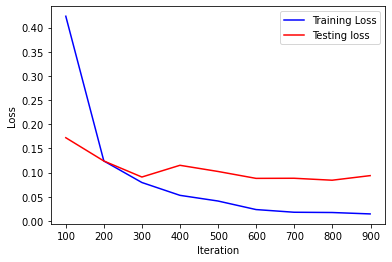

In [483]:
train_iter = 0
losses = []
test_losses = []
steps = []
running_loss = 0.0
running_acc = 0.0

lr_init = 0.001
lr_factor = 0.1
weight_decay_factor = 1e-4
lr_schedule_milestones = [0.5 * TRAIN_ITERS, 0.75 * TRAIN_ITERS, 0.9 * TRAIN_ITERS]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr_init)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

train_copy = deepcopy(uwave.train_x).reshape(TRAIN_DATASET_SIZE, 3, 315) if not isinstance(net, MLP) else uwave.train_x
test_copy = deepcopy(uwave.test_x).reshape(TEST_DATASET_SIZE, 3, 315) if not isinstance(net, MLP) else uwave.test_x

train_dataset = TensorDataset(torch.Tensor(train_copy), torch.Tensor(uwave.train_y).type(torch.LongTensor))
test_dataset = TensorDataset(torch.Tensor(test_copy), torch.Tensor(uwave.test_y).type(torch.LongTensor))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_data_provider = loopy_test_loader(test_loader)

for epoch in range(int(EPOCHS)):  # loop over the dataset multiple times
    print(f'Start epoch {epoch + 1}')
    for i, data in enumerate(train_loader, 0):
        lr_scheduler.step()

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += top_k_accuracy(1, labels, outputs)

        if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
            train_loss = float(running_loss) / REPORT_TRAIN_EVERY
            train_acc = float(running_acc) / REPORT_TRAIN_EVERY

            print(f'[{epoch + 1}, {i + 1}, {train_iter}]  LR: {lr_scheduler.get_lr()[-1]:5f}, loss: {train_loss:.5f}, acc: {train_acc:.5f}')

            losses.append(train_loss)
            steps.append(train_iter)

            running_loss = 0
            running_acc = 0

        if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:
            net.eval()

            with torch.no_grad():
                test_iter = 0
                test_loss = 0
                correct = 0

                while test_iter < TEST_ITERS:
                    test_dataset = next(test_data_provider)
                    test_inputs, test_labels = test_dataset[0].to(device), test_dataset[1].to(device)
                    out = net(test_inputs)

                    test_loss += criterion(out, test_labels)
                    correct += top_k_accuracy(1, test_labels, out)
                    test_iter += 1

                avg_test_loss = float(test_loss) / TEST_ITERS
                avg_acc = float(correct) / TEST_ITERS
                test_losses.append(avg_test_loss)

                print(f'[{epoch + 1}, {i + 1}] avg_test_loss: {avg_test_loss:.5f}, avg_test_acc: {avg_acc:.2f}')

            net.train()

        if train_iter % PLOT_EVERY == PLOT_EVERY - 1:
            plot_losses(losses, test_losses, steps, train_iter)

        train_iter += 1

print('Finished Training')
plot_losses(losses, test_losses, steps, train_iter)
net.eval()
with torch.no_grad():
    print(classification_report(
            uwave.test_y,
            net(torch.Tensor(test_copy).to(device)).cpu().topk(1, 1, True, True)[1].t().detach().numpy().reshape(TEST_DATASET_SIZE)
        ))

In [484]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
pred = []
with torch.no_grad():
    test_copy = deepcopy(uwave.test_x).reshape(TEST_DATASET_SIZE, 3, 315) if not isinstance(net, MLP) else uwave.test_x
    pred = net(torch.Tensor(test_copy).to(device)).cpu().topk(1, 1, True, True)[1].t().detach().numpy().reshape(TEST_DATASET_SIZE)
print(accuracy_score(uwave.test_y, pred))
print(precision_score(uwave.test_y, pred, average='macro'), precision_score(uwave.test_y, pred, average='micro'))
print(recall_score(uwave.test_y, pred, average='macro'), recall_score(uwave.test_y, pred, average='micro'))
print(f1_score(uwave.test_y, pred, average='macro'), f1_score(uwave.test_y, pred, average='micro'))

0.9743303571428571
0.9745175320654407 0.9743303571428571
0.9750393681112024 0.9743303571428571
0.9745994149673174 0.9743303571428571


Text(0.5, 1.0, 'Confusion Matrix')

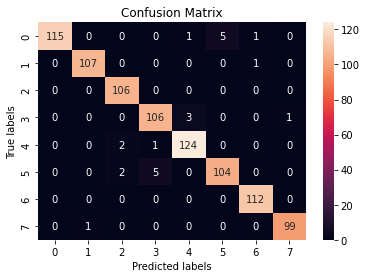

In [485]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(uwave.test_y, pred), annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [474]:
class ClassifierWrapper:
    def __init__(self, **kwargs):
        self.model = kwargs.get('model')
        self.num_classes = kwargs.get('num_classes')
        self.net = None

    def predict(self, x):
        self.net.eval()
        test_copy = x.reshape(x.shape[0], 3, 315) if not isinstance(self.net, MLP) else x
        pred = self.net(torch.Tensor(test_copy).to(device)).cpu().topk(1, 1, True, True)[1].t().detach().numpy().reshape(x.shape[0])
        return pred

    def get_params(self, deep=True):
        return {"model": self.model, "num_classes": self.num_classes}

    def set_params(self, **parameters):
        print('set_params', parameters)
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x, y):
        if not self.net:
            self.net = self.model(self.num_classes).to(device)

        lr_init = 0.001
        lr_factor = 0.1
        lr_schedule_milestones = [0.5 * TRAIN_ITERS, 0.75 * TRAIN_ITERS, 0.9 * TRAIN_ITERS]
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=lr_init)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

        train_copy = x.reshape(x.shape[0], 3, 315) if not isinstance(self.net, MLP) else x
        train_dataset = TensorDataset(torch.Tensor(train_copy), torch.Tensor(y).type(torch.LongTensor))
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

        self.net.train()
        for epoch in range(int(EPOCHS)):
            for i, data in enumerate(train_loader, 0):
                lr_scheduler.step()
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self

In [446]:
@timer
def print_report(classifiers):
    all_scores = {}

    scoring = ['accuracy', 'precision_micro', 'recall_micro', 'f1_micro']
    all_data = np.concatenate([uwave.train_x, uwave.test_x])
    all_labels = np.concatenate([uwave.train_y, uwave.test_y])

    for name, classifier in classifiers.items():
        print(f'Started validation for {name}: {classifier}')
        scores = cross_validate(classifier, all_data, all_labels, cv=5, scoring=scoring, verbose=3,
                                n_jobs = 1 if isinstance(classifier, ClassifierWrapper) or isinstance(classifier, XGBClassifier) else -1)
        scores.pop('score_time')
        scores = {key: (np.mean(value), np.std(value)) for key, value in scores.items()}
        all_scores[name] = scores
    return all_scores

best_clf_all_data_uwave = {
    'RandomForest {max_depth: 100, n_estimators: 1000}':
        RandomForestClassifier(n_estimators=1000, max_depth=100),
    'RandomForest {max_depth: 10, n_estimators: 1000}':
        RandomForestClassifier(n_estimators=1000, max_depth=10),
    'RandomForest {max_depth: 500, n_estimators: 100, max_samples=0.5}':
        RandomForestClassifier(n_estimators=100, max_depth=500, max_samples=0.5),
    'SVC {C: 5, gamma: 0.001, kernel: rbf}': SVC(C=5, gamma=0.001, kernel='rbf'),
    'SVC {C: 5, gamma: 0.0001, kernel: rbf}': SVC(C=5, gamma=0.0001, kernel='rbf'),
    'SVC {C: 0.2, gamma: 0.001, kernel: poly}': SVC(C=0.2, gamma=0.001, kernel='poly'),
    'XGBClassifier {learning_rate: 0.2, max_depth: 5, n_estimators: 200}':
        XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=200, tree_method='gpu_hist'),
    'XGBClassifier {learning_rate: 0.3, max_depth: 5, n_estimators: 100}':
        XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=100, tree_method='gpu_hist'),
    'XGBClassifier {learning_rate: 0.2, max_depth: 10, n_estimators: 200}':
        XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200, tree_method='gpu_hist'),
}

best_clf_all_data_pems = {
    'RandomForest {max_depth: 50, max_samples: 0.5, n_estimators: 1000}':
        RandomForestClassifier(n_estimators=1000, max_depth=50, max_samples=0.5),
    'RandomForest {max_depth: 100,n_estimators: 1000}':
        RandomForestClassifier(n_estimators=1000, max_depth=100),
    'RandomForest {max_depth: 50, n_estimators: 1000}':
        RandomForestClassifier(n_estimators=1000, max_depth=50),
    'SVC {C: 0.2, gamma: 0.001, kernel: linear}': SVC(C=0.2, gamma=0.001, kernel='linear'),
    'SVC {C: 5, gamma: 0.0001, kernel: linear}': SVC(C=5, gamma=0.0001, kernel='linear'),
    'SVC {C: 5, gamma: 0.001, kernel: linear}': SVC(C=5, gamma=0.001, kernel='linear'),
    'XGBClassifier {learning_rate: 0.3, max_depth: 8, n_estimators: 100}':
        XGBClassifier(learning_rate=0.3, max_depth=8, n_estimators=100, tree_method='gpu_hist'),
}

neuro_networks = {
    'MPL': ClassifierWrapper(model=MLP, num_classes=8),
    'LeNet': ClassifierWrapper(model=LeNet, num_classes=8),
    'LSTM': ClassifierWrapper(model=LSTM, num_classes=8),
}

all_scores = print_report(best_clf_all_data_pems)
print(*all_scores.items(), sep='\n')

Started validation for RandomForest {max_depth: 50, max_samples: 0.5, n_estimators: 1000}: RandomForestClassifier(max_depth=50, max_samples=0.5, n_estimators=1000)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   53.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.7s finished


Started validation for RandomForest {max_depth: 100,n_estimators: 1000}: RandomForestClassifier(max_depth=100, n_estimators=1000)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Started validation for RandomForest {max_depth: 50, n_estimators: 1000}: RandomForestClassifier(max_depth=50, n_estimators=1000)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Started validation for SVC {C: 0.2, gamma: 0.001, kernel: linear}: SVC(C=0.2, gamma=0.001, kernel='linear')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Started validation for SVC {C: 5, gamma: 0.0001, kernel: linear}: SVC(C=5, gamma=0.0001, kernel='linear')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Started validation for SVC {C: 5, gamma: 0.001, kernel: linear}: SVC(C=5, gamma=0.001, kernel='linear')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Started validation for XGBClassifier {learning_rate: 0.3, max_depth: 8, n_estimators: 100}: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  accuracy: (test=0.965) f1_micro: (test=0.965) precision_micro: (test=0.965) recall_micro: (test=0.965) total time=  13.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV] END  accuracy: (test=0.960) f1_micro: (test=0.960) precision_micro: (test=0.960) recall_micro: (test=0.960) total time=  12.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV] END  accuracy: (test=0.953) f1_micro: (test=0.953) precision_micro: (test=0.953) recall_micro: (test=0.953) total time=  12.0s
[CV] END  accuracy: (test=0.959) f1_micro: (test=0.959) precision_micro: (test=0.959) recall_micro: (test=0.959) total time=  11.9s
[CV] END  accuracy: (test=0.963) f1_micro: (test=0.963) precision_micro: (test=0.963) recall_micro: (test=0.963) total time=  12.1s
Finished in 279.53545689582825s
('RandomForest {max_depth: 50, max_samples: 0.5, n_estimators: 1000}', {'fit_time': (49.380002450942996, 0.04693465534788184), 'test_accuracy': (0.9533257681564246, 0.007427555237782329), 'test_precision_micro': (0.9533257681564246, 0.007427555237782329), 'test_recall_micro': (0.9533257681564246, 0.007427555237782329), 'test_f1_micro': (0.9533257681564246, 0.007427555237782329)})
('RandomForest {max_depth: 100,n_estimators: 1000}', {'fit_time': (71.91700053215027, 0.13168418991175002), 'test_accuracy': (0.9606958300079809, 0.004209822329195408), 'test_precision_micr

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [449]:
scores_df = pd.DataFrame(
    {k: [f'{mean:.03f}({std:.05f})' for mean, std in v.values()] for k, v in all_scores.items()},
     columns=all_scores.keys(),
     index=list(all_scores.values())[0].keys()).transpose()
scores_df.to_excel('table all data pems.xlsx')

Text(0.5, 1.0, 'Confusion Matrix')

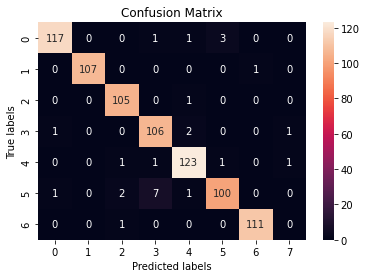

In [452]:
cm1 = [[ 87,   0,  9,   2,   0,  22,   0,   2],
 [  0, 105,   0,   0,   0,   0,   2,   1],
 [  7,  0,  81,   0,   5,   1,  12,   0],
 [  1,   0,   1,  95,   9,   2,  0,  2],
 [  0,  0,   4,   8, 114,   0,   0,   1],
 [ 20,   0,   1,   6,   0,  83,   0,   1],
 [  3,   2,   9,   1,   0,   1,  96,   0],
 [  0,   1,   2,   2,   1,   0,   2,  92]]

cm2 = [[119,   0,   0,   1,   0,   2,   0,   0],
 [  0, 108,   0,   0,   0,   0,   0,   0],
 [  0,   0, 106,   0,   0,   0,   0,   0],
 [  0,   0,   0, 105,   4,   0,   0,   1],
 [  0,   0,   1,   1, 125,   0,   0,   0],
 [  0,   0,   1,   4,   1, 105,   0,   0],
 [  0,   0,   0,   0,   0,   0, 112,   0],
 [  0,  0,   0,   0,   0,   0,   0, 100]]

cm3 = [[117,   0,   0,   1,   1,   3,   0,   0],
 [  0, 107,   0,   0,   0,   0,   1,   0],
 [  0,   0, 105,   0,   1,   0,   0,   0],
 [  1,   0,   0, 106,   2,   0,   0,   1],
 [  0,   0,   1,   1, 123 ,  1 ,  0,   1],
 [  1,   0,   2,   7,   1, 100,   0,   0],
 [  0,   0,   1,   0,   0,   0, 111,   0]]


ax= plt.subplot()
sns.heatmap(cm3, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')